In [1]:
import numpy as np
import pandas as pd
import os
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from promoter_modelling.utils import diversity

np.random.seed(97)

In [2]:
final_sequences = pd.read_parquet("final_sequences_v6.parquet")

In [3]:
final_sequences["experiment_id"] = final_sequences.apply(lambda x: f'{x["design_model"]}_{x["target_cell_exp_weight"]}_{x["diversity_loss_coef"]}', axis=1)

In [4]:
final_sequences

,designed_for,sequence,design_model,target_cell_exp_weight,diversity_loss_coef,entropy_loss_coef,THP1,Jurkat,K562,experiment_id
0,THP1,CGACGCCAACCGAGGAAACGGAAGCAGAAGCAGAAGCAGAAGCGAA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.629622,0.379506,0.336685,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
1,THP1,CGACGCCAACCGAGGAAGCGGAAGCAGAAGCAGAAGCAGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.687961,0.559623,0.479022,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
2,THP1,CGACGCCAACCGAGGAAACCGAAGCGGAAGCAGAAGCTGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.599566,0.389701,0.326611,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
3,THP1,CGACGCCAACCGAGGAAACGGAAGCAGAAGCAGAAGCAGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.664889,0.414526,0.354171,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
4,THP1,CGACGCCAACCGAGGAAACAGAAGGAAACGGAAGCAGAAGCAGAAG...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.853674,0.618269,0.605900,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
...,...,...,...,...,...,...,...,...,...,...
4679995,K562,GGGGGGCGTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.676364,0.917514,1.550400,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679996,K562,GCCCCTTTTCTTTTGGGGGGGGGGGGGGGGGGGGGGGGGCCCCTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.615660,0.885715,1.572785,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679997,K562,TTTTTTGGGGGGGGGGGGGGGGCGGGACCCCCTTTTTTTTTTTTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.583300,0.760906,1.487105,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679998,K562,GCGCCTTCTTTTTCGGGGGGGGGGGGGGGGCGGGGGGGCGGGGCGC...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.738684,1.216584,1.762630,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...


In [5]:
all_cells = ["THP1", "Jurkat", "K562"]
all_experiment_ids = list(set(final_sequences["experiment_id"]))

In [6]:
all_stats = {}
all_stats["experiment_id"] = []
all_stats["designed_for"] = []
all_stats["average_similarity"] = []
all_stats["average_num_motifs"] = []
all_stats["average_num_unique_motifs"] = []

all_stats["avg_target_cell_exp"] = []
all_stats["avg_diff"] = []

all_stats["target_cell_exp_weight"] = []
all_stats["diversity_loss_coef"] = []

all_stats["coms_alpha"] = []
all_stats["coms_total_rounds"] = []
all_stats["coms_mutation_steps"] = []

np.random.seed(97)

for cell in all_cells:
    print(cell)
    other_cells = [c for c in ["THP1", "Jurkat", "K562"] if c != cell]
    print(other_cells)
    
    for exp in tqdm(all_experiment_ids):
#         print(exp)
        subset = final_sequences[(final_sequences["designed_for"] == cell) & (final_sequences["experiment_id"] == exp)].reset_index(drop=True)
        if subset.shape[0] == 0:
            continue
        
        # randomly sample some sequences
        random_sample = np.random.randint(0, len(subset), 500)
        subset = subset.iloc[random_sample]
#         print(subset.shape)
        
        # get their average pairwise edit distance
        random_seqs = list(subset["sequence"])
#         print(len(random_seqs))
        average_similarity, average_num_motifs, average_num_unique_motifs, similarity_matrix = diversity.compute_average_pairwise_vierstra_motif_occurrences_similarity(random_seqs, vierstra_motifs_data_dir="./vierstra_motifs")
        
        # get their average exp and diff
        avg_target_cell_exp = subset[cell].mean()
        avg_diff = (subset[cell] - np.max(subset[other_cells], axis=1)).mean()
        
        # hyperparams
        target_cell_exp_weight = float(exp.split("_")[-2])
        diversity_loss_coef = float(exp.split("_")[-1])
        coms_alpha = float(exp.split("_")[1])
        coms_total_rounds = float(exp.split("_")[4])
        coms_mutation_steps = float(exp.split("_")[10][:-len(".pkl")])
        
        # add everything to the dataframe
        all_stats["experiment_id"].append(exp)
        all_stats["designed_for"].append(cell)
        all_stats["average_similarity"].append(average_similarity)
        all_stats["average_num_motifs"].append(average_num_motifs)
        all_stats["average_num_unique_motifs"].append(average_num_unique_motifs)
        
        all_stats["avg_target_cell_exp"].append(avg_target_cell_exp)
        all_stats["avg_diff"].append(avg_diff)
        
        all_stats["target_cell_exp_weight"].append(target_cell_exp_weight)
        all_stats["diversity_loss_coef"].append(diversity_loss_coef)
        all_stats["coms_alpha"].append(coms_alpha)
        all_stats["coms_total_rounds"].append(coms_total_rounds)
        all_stats["coms_mutation_steps"].append(coms_mutation_steps)

THP1
['Jurkat', 'K562']


100%|███████████████████████████████████████| 693/693 [00:00<00:00, 1047.02it/s]
Use --max-stored-scores to allocate more space for storing motif matches.
100%|█████████████████████████████████████████| 156/156 [19:16<00:00,  7.42s/it]


Jurkat
['THP1', 'K562']


100%|█████████████████████████████████████████| 156/156 [14:55<00:00,  5.74s/it]


K562
['THP1', 'Jurkat']


100%|█████████████████████████████████████████| 156/156 [22:53<00:00,  8.81s/it]


In [7]:
all_stats = pd.DataFrame(all_stats)

In [8]:
all_stats

,experiment_id,designed_for,average_similarity,average_num_motifs,average_num_unique_motifs,avg_target_cell_exp,avg_diff,target_cell_exp_weight,diversity_loss_coef,coms_alpha,coms_total_rounds,coms_mutation_steps
0,coms_0.03_total_rounds_3_gd_steps_3_mutation_s...,THP1,0.870946,60.936,10.964,2.130953,1.181629,1.50,1.0,0.03,3.0,3.0
1,coms_0.1_total_rounds_3_gd_steps_3_mutation_st...,THP1,0.959496,1540.852,32.176,0.424081,0.089125,2.00,10.0,0.10,3.0,3.0
2,coms_0.3_total_rounds_5_gd_steps_10_mutation_s...,THP1,0.976837,1733.086,26.096,0.419112,0.255183,2.00,10.0,0.30,5.0,10.0
3,coms_0.1_total_rounds_3_gd_steps_3_mutation_st...,THP1,0.940830,226.424,12.862,0.297906,0.450377,1.50,5.0,0.10,3.0,3.0
4,coms_0.1_total_rounds_3_gd_steps_3_mutation_st...,THP1,0.856884,53.088,9.918,1.592148,0.899995,1.50,1.0,0.10,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
229,coms_0.3_total_rounds_5_gd_steps_10_mutation_s...,K562,0.997043,353.860,26.670,2.472157,1.995366,1.15,1.0,0.30,5.0,10.0
230,coms_0.1_total_rounds_3_gd_steps_10_mutation_s...,K562,0.995355,1409.850,24.686,2.009901,1.332936,1.15,10.0,0.10,3.0,10.0
231,coms_0.1_total_rounds_3_gd_steps_10_mutation_s...,K562,0.603083,319.906,17.016,3.136739,0.930811,2.00,10.0,0.10,3.0,10.0
232,coms_0.1_total_rounds_3_gd_steps_3_mutation_st...,K562,0.991647,392.472,38.024,2.915461,2.067585,2.00,1.0,0.10,3.0,3.0


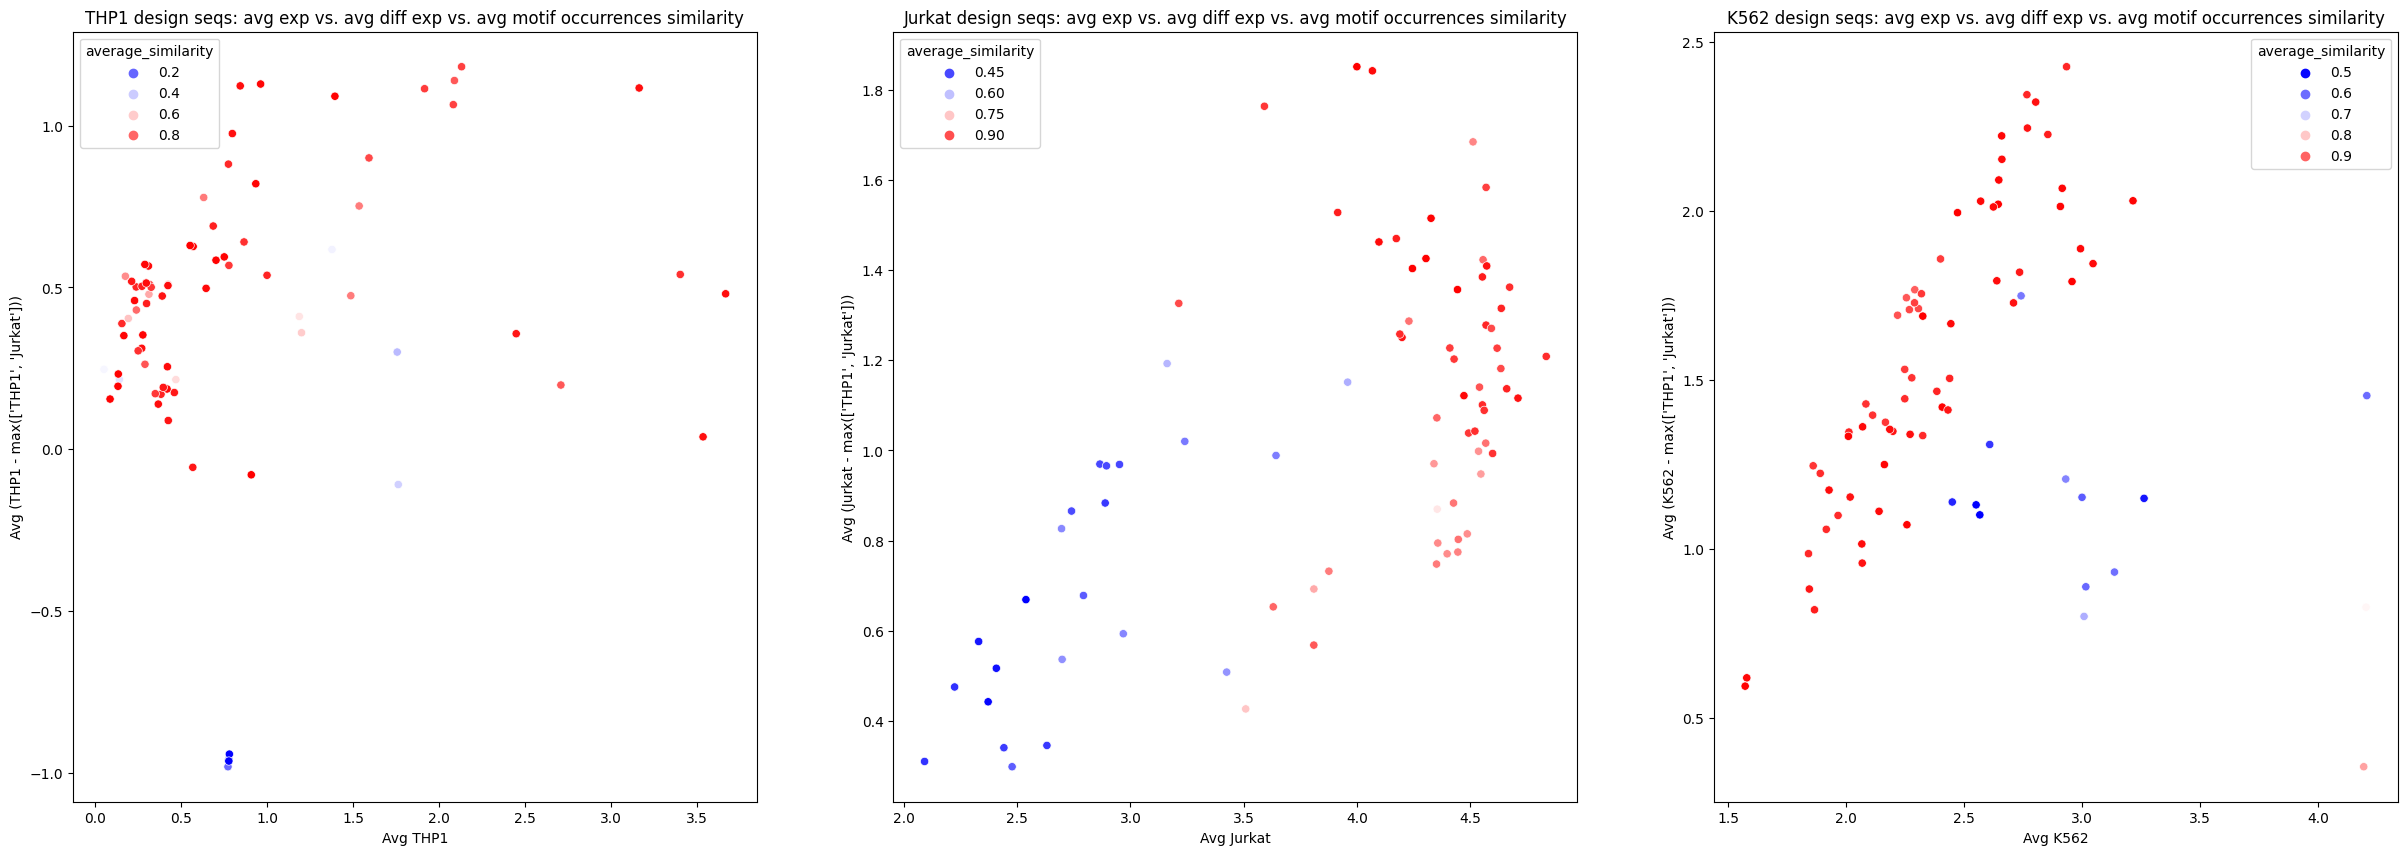

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_stats[all_stats["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="avg_target_cell_exp", y="avg_diff", hue="average_similarity", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: avg exp vs. avg diff exp vs. avg motif occurrences similarity")
    ax[i].set_xlabel(f"Avg {cell}")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

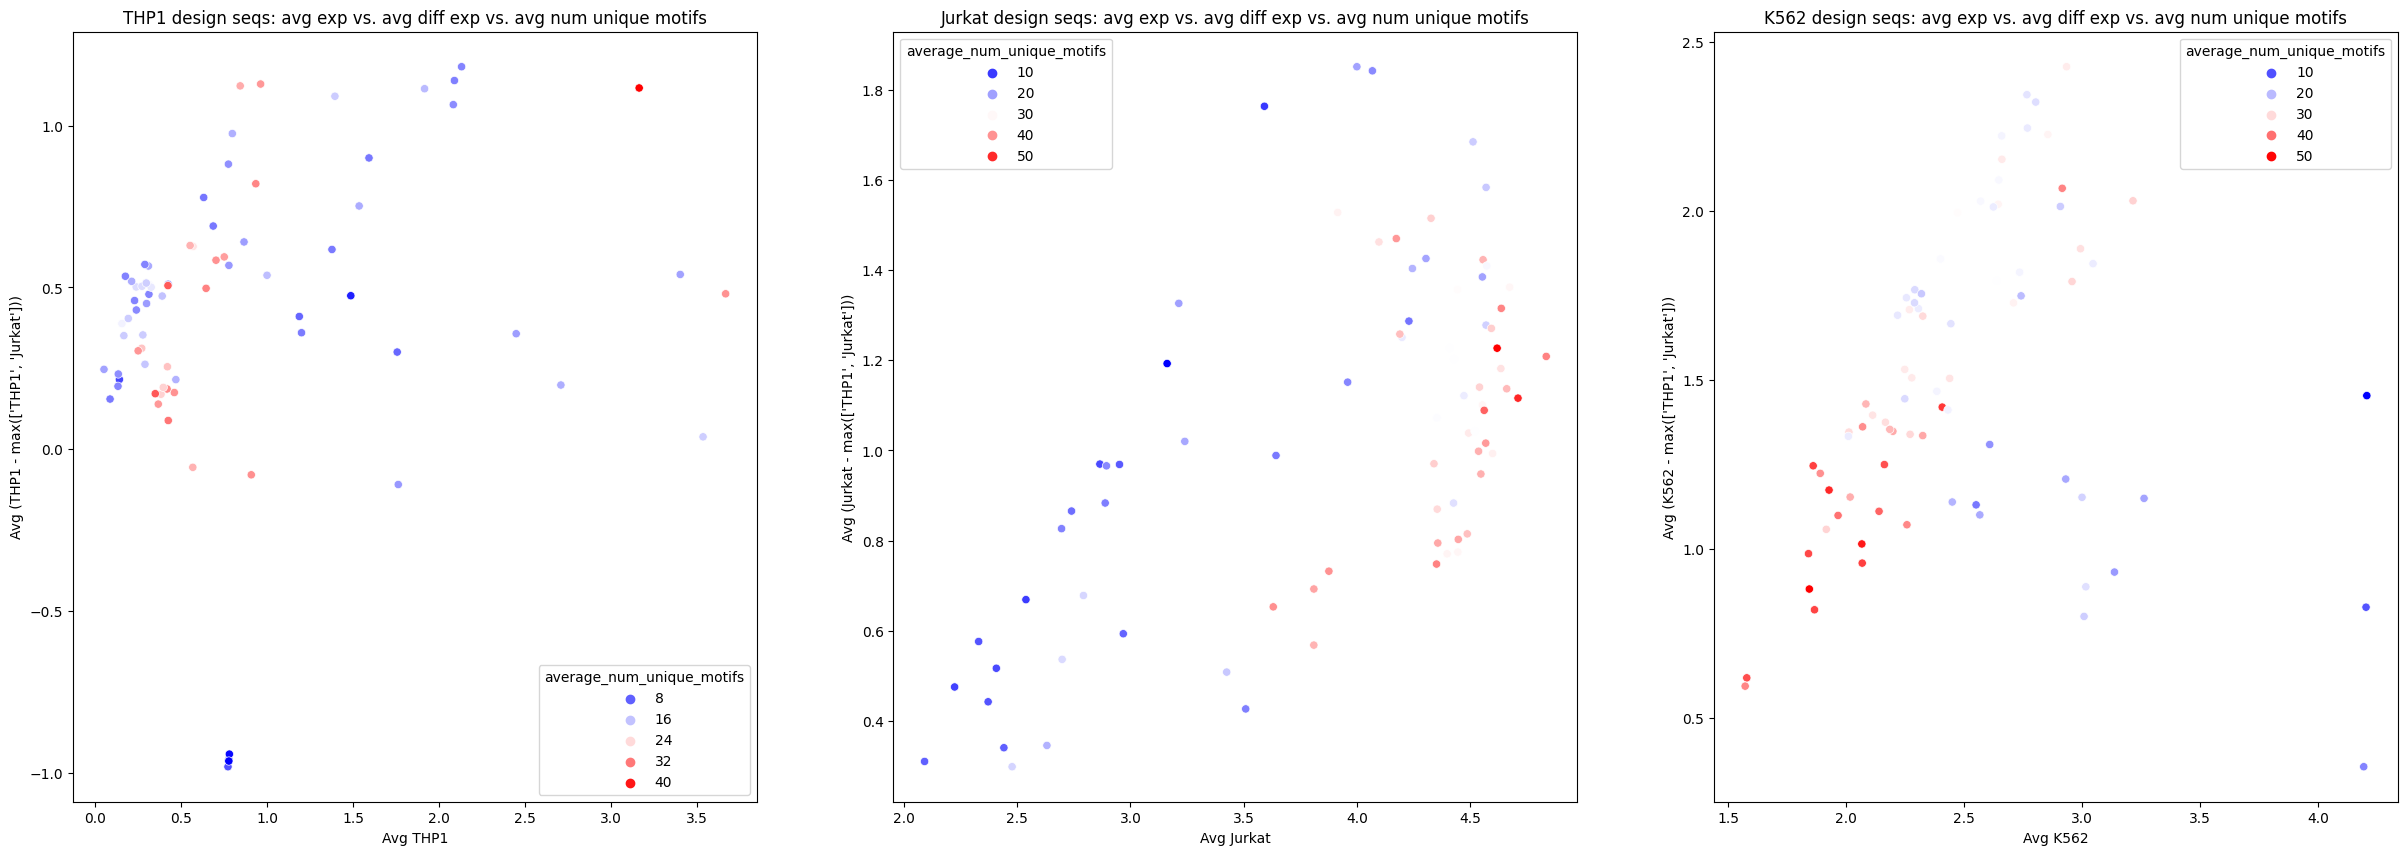

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_stats[all_stats["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="avg_target_cell_exp", y="avg_diff", hue="average_num_unique_motifs", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: avg exp vs. avg diff exp vs. avg num unique motifs")
    ax[i].set_xlabel(f"Avg {cell}")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

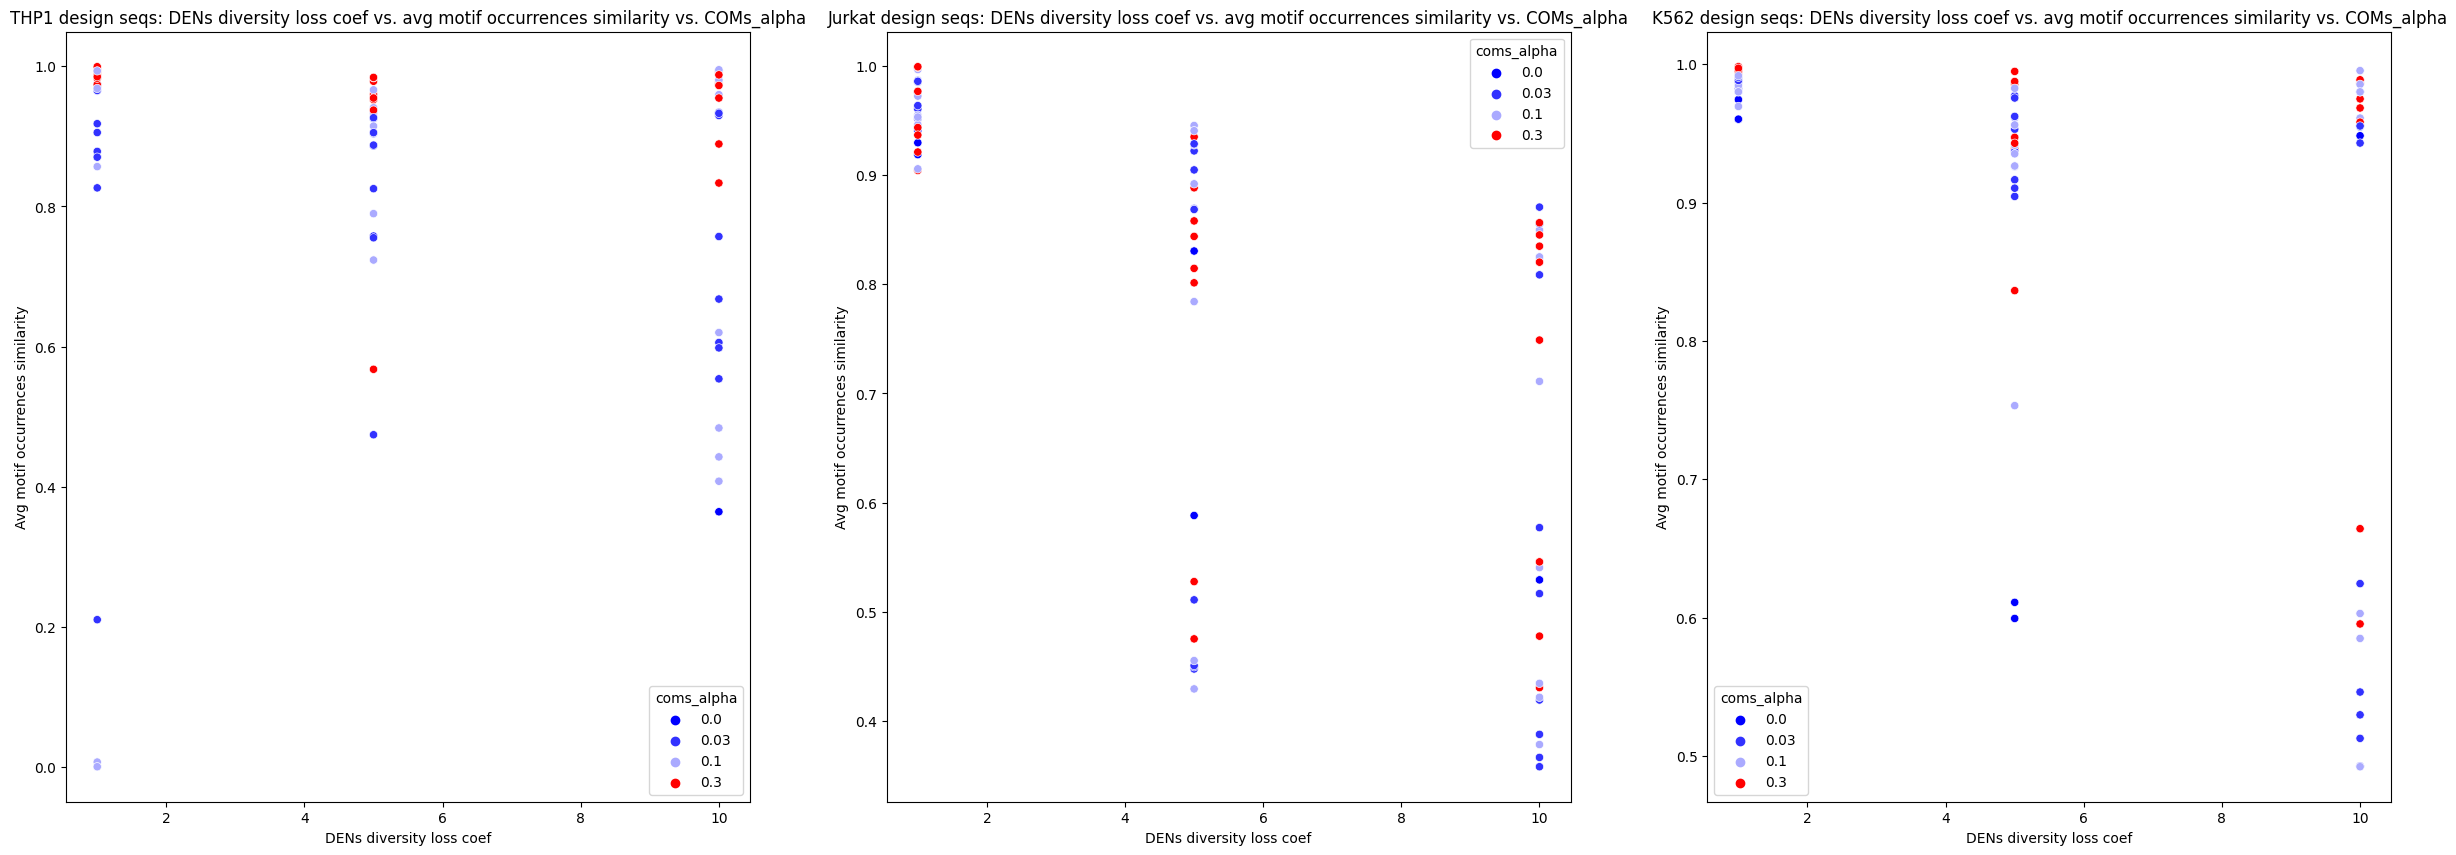

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_stats[all_stats["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="diversity_loss_coef", y="average_similarity", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: DENs diversity loss coef vs. avg motif occurrences similarity vs. COMs_alpha")
    ax[i].set_xlabel(f"DENs diversity loss coef")
    ax[i].set_ylabel(f"Avg motif occurrences similarity")

plt.show()

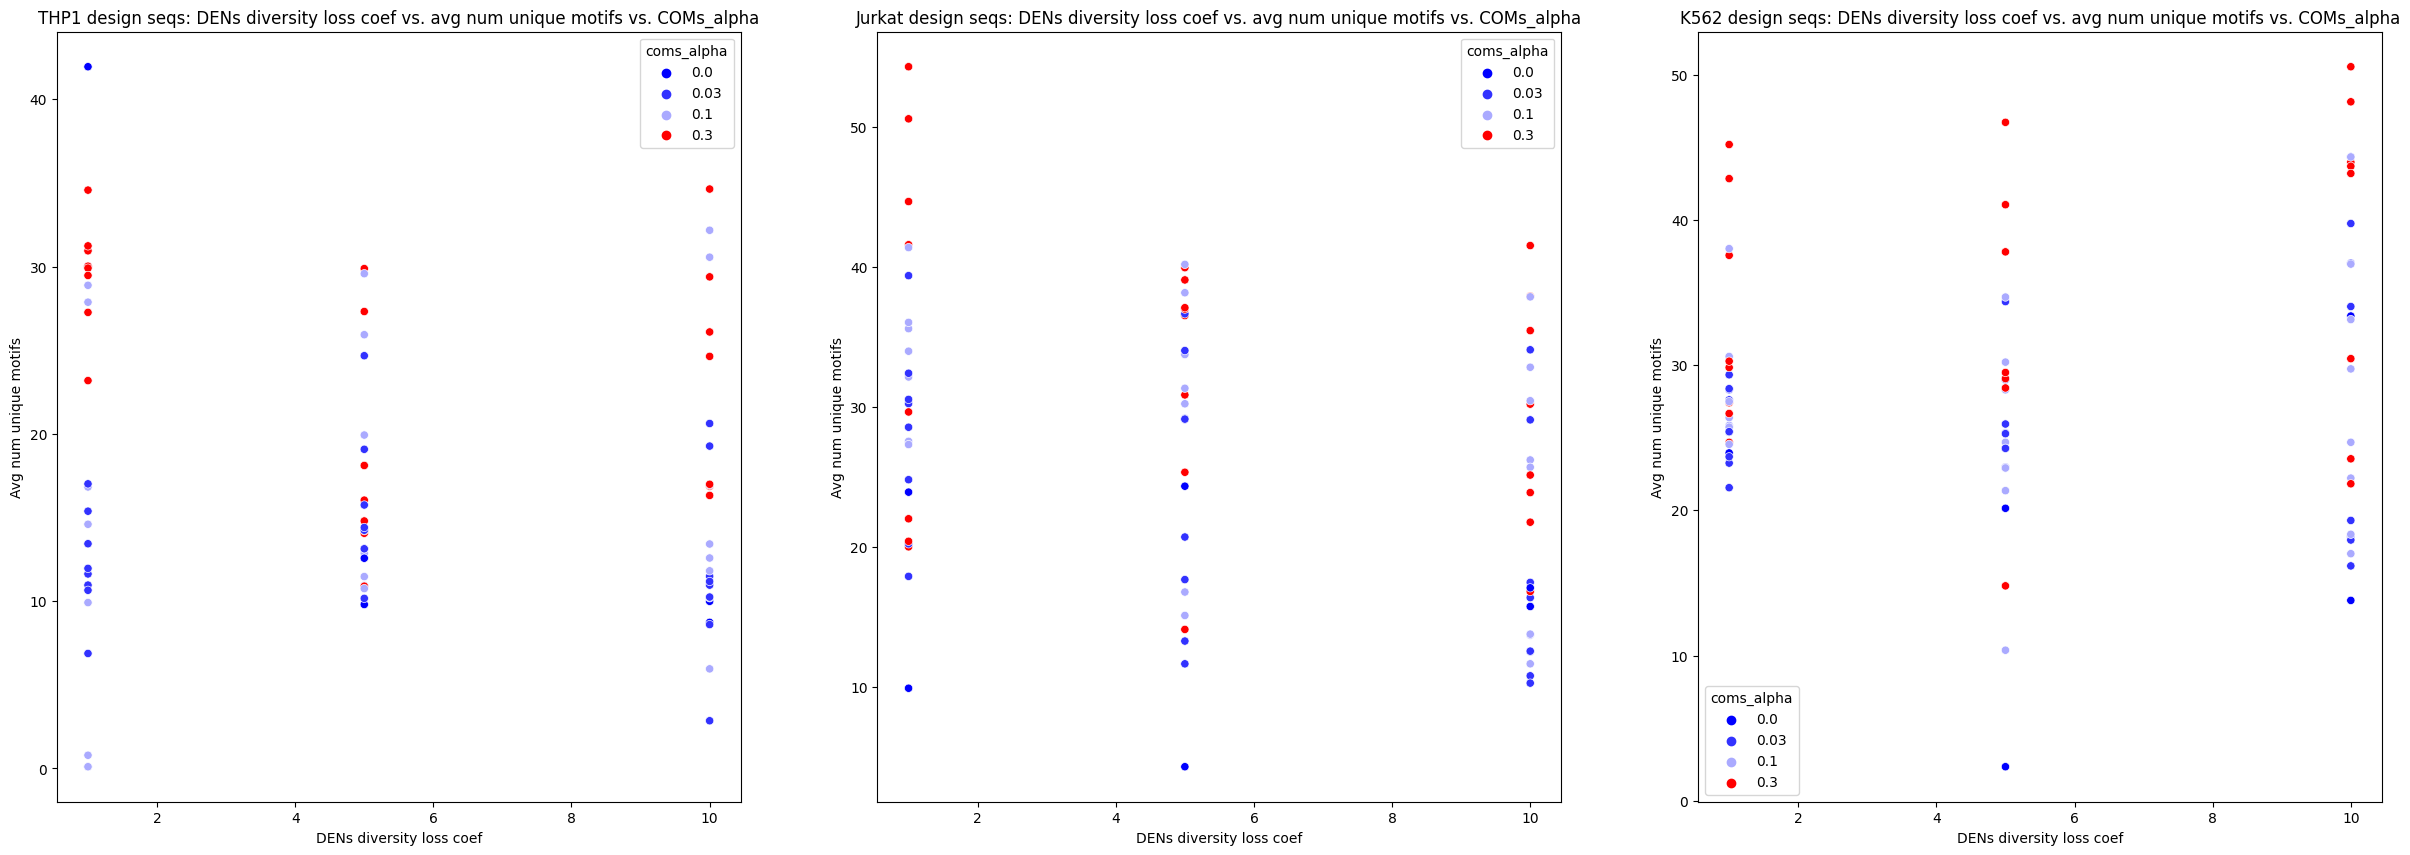

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_stats[all_stats["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="diversity_loss_coef", y="average_num_unique_motifs", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: DENs diversity loss coef vs. avg num unique motifs vs. COMs_alpha")
    ax[i].set_xlabel(f"DENs diversity loss coef")
    ax[i].set_ylabel(f"Avg num unique motifs")

plt.show()